In [1]:
%matplotlib inline

# Importaciones de Python estándar
import os
from subprocess import call

# Importaciones de NumPy
import numpy as np

# Importaciones de Matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Importaciones de Seaborn
import seaborn as sns 

# Importaciones de SciPy
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Importaciones de IPython
from IPython.display import display, clear_output

# Importaciones de ipywidgets
from ipywidgets import interact, widgets, FloatSlider, FloatText, fixed
from ipywidgets import widgets as wgt



# Actualización de los parámetros de Matplotlib
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
                                    
import torch
import torch.nn as nn
# Definir el colormap personalizado
rgb = {'red': ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 1.0, 1.0)),

        'green': ((0.0, 0.0, 0.0),
                    (0.5, 1.0, 1.0),
                    (1.0, 0.0, 0.0)),

        'blue': ((0.0, 1.0, 1.0),
                (0.5, 1.0, 1.0),
                (1.0, 0.0, 0.0))
        }

# Definir el colormap
rgb = LinearSegmentedColormap('RedGreenBlue', rgb)

In [52]:
import numpy as np
# Specify the file path
file_path = 'inputs/preassures.txt'

# Load the file
data = np.loadtxt(file_path)

x = data[:, 0]
y = data[:, 1]
t = data[:, 2]
u = data[:, 3]


In [53]:
np.shape(u), np.shape(x), np.shape(y), np.shape(t)  # Asegúrate de que las dimensiones sean correctas

((2520000,), (2520000,), (2520000,), (2520000,))

In [54]:
unique_t, counts = np.unique(t, return_counts=True)
num_unique_t = len(unique_t)
num_unique_t

28

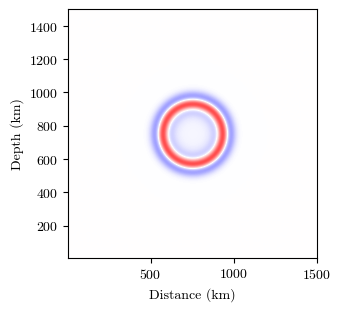

In [66]:
unique_t, counts = np.unique(t, return_counts=True)
num_unique_t = len(unique_t)
# Asegúrate de que x, y y u tengan la misma longitud
assert len(x) == len(y) == len(u)
x_splits = np.array_split(x, num_unique_t)
y_splits = np.array_split(y, num_unique_t)
u_splits = np.array_split(u, num_unique_t)
x_test = x_splits[10]
y_test = y_splits[10]
u_test = u_splits[10]
wavefields = u_test.reshape((len(np.unique(y_test)), len(np.unique(x_test))))

# Definir los límites de los ejes
x_min, x_max = np.min(x_test), np.max(x_test)
y_min, y_max = np.min(y_test), np.max(y_test)
wavefields_min, wavefields_max = np.min(wavefields), np.max(wavefields)

# Crear la figura y el subplot
plt.figure(figsize=(4, 3))
plt.xlabel('Distance (km)', fontsize=10)
plt.ylabel('Depth (km)', fontsize=10)

# Mostrar el subplot
plt.imshow(wavefields, extent=[x_min, x_max, y_min, y_max], aspect=1, cmap=rgb, alpha=0.7, vmin=-wavefields_max, vmax=wavefields_max)

# Mostrar la figura
plt.show()




In [57]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),  # Cambia N_INPUT a 3
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x, y, t):
        # Convierte x, y, t a tensores de PyTorch si aún no lo son
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().unsqueeze(1)
        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().unsqueeze(1)
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().unsqueeze(1)

        # Concatena x, y, t a lo largo del eje 1 (columnas)
        x = torch.cat((x, y, t), dim=1)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(3,1,100,10)  # Cambia el primer argumento a 3
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []

T_1 =int(2520000*0.5)
T_2 =int(2520000*0.7)


x_data = x[T_1:T_2:10]
y_data = y[T_1:T_2:10]
t_data = t[T_1:T_2:10]

u_data = u / u.max() 

u_data = u_data[T_1:T_2:10]

#x_data = x_data / x_data.max() 
#y_data = y_data / y_data.max() 
#t_data = t_data / t_data.max() 

for i in range(100):
    optimizer.zero_grad()
    uh = model(x_data,y_data,t_data)
    if not torch.is_tensor(u_data):
        u_data = torch.from_numpy(u_data).float().unsqueeze(1)  # Convierte u a un tensor de PyTorch
    loss = torch.mean((uh-u_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

    # Imprime el número de iteración y la pérdida cada 100 iteraciones
    if i % 10 == 0:
        print(f"Iteration: {i}, Loss: {loss.item()}")

Iteration: 0, Loss: 0.016865883022546768
Iteration: 10, Loss: 1.7937645679921843e-05
Iteration: 20, Loss: 0.00016763921303208917
Iteration: 30, Loss: 5.918595888942946e-06
Iteration: 40, Loss: 2.387211861787364e-05
Iteration: 50, Loss: 8.208989129343536e-06
Iteration: 60, Loss: 7.268554782058345e-06
Iteration: 70, Loss: 5.972507096885238e-06
Iteration: 80, Loss: 5.953518211754272e-06
Iteration: 90, Loss: 5.6384969866485335e-06


In [13]:
t

array([0.125, 0.125, 0.125, ..., 3.5  , 3.5  , 3.5  ])

In [58]:
uh = model(x,y,t)


In [59]:
uh = uh.detach().numpy()
np.shape(uh)

(2520000, 1)

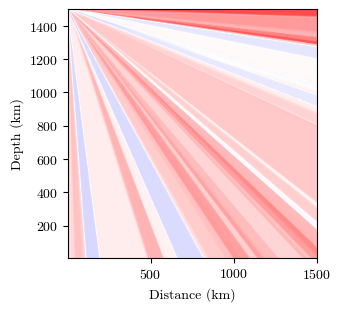

In [65]:
unique_t, counts = np.unique(t, return_counts=True)
num_unique_t = len(unique_t)

x_splits = np.array_split(x, num_unique_t)
y_splits = np.array_split(y, num_unique_t)
u_splits = np.array_split(uh, num_unique_t)
x_test = x_splits[18]
y_test = y_splits[18]
u_test = u_splits[18]
wavefields = u_test.reshape((len(np.unique(y_test)), len(np.unique(x_test))))

# Definir los límites de los ejes
x_min, x_max = np.min(x_test), np.max(x_test)
y_min, y_max = np.min(y_test), np.max(y_test)
wavefields_min, wavefields_max = np.min(wavefields), np.max(wavefields)

# Crear la figura y el subplot
plt.figure(figsize=(4, 3))
plt.xlabel('Distance (km)', fontsize=10)
plt.ylabel('Depth (km)', fontsize=10)

# Mostrar el subplot
plt.imshow(wavefields, extent=[x_min, x_max, y_min, y_max], aspect=1, cmap=rgb, alpha=0.7, vmin=-wavefields_max, vmax=wavefields_max)

# Mostrar la figura
plt.show()

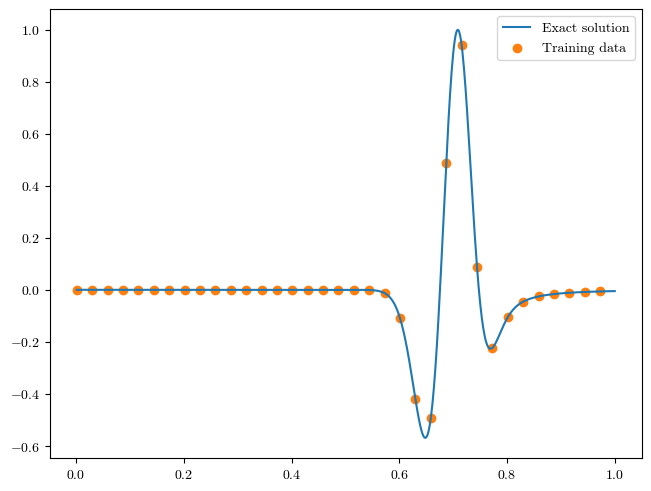

In [9]:
indices = np.where((y == 850) & (x == 1200))
u_values = u[indices]
t_values = t[indices]



u_values = u_values / u_values.max() 
t_values = t_values / t_values.max() 

#t_values = 2 * (t_values - t_values.min()) / (t_values.max() - t_values.min()) - 1

u_values = torch.FloatTensor(u_values).reshape(-1, 1)
#u_values = torch.tensor(u_values, requires_grad=True)

t_values = torch.FloatTensor(t_values).reshape(-1, 1)
#t_values = torch.tensor(t_values, requires_grad=True)


u_data = u_values[0:700:20]
t_data = t_values[0:700:20]  

plt.figure()
plt.plot(t_values, u_values, label="Exact solution")
plt.scatter(t_data, u_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [13]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-1.1, 1.1)
    #plt.text(4.065,50.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


 
      
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,100,10)#.double()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(t_values)
    loss = torch.mean((yh-u_values)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    # Imprime el número de iteración y la pérdida cada 100 iteraciones
    if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {loss.item()}")


    # plot the result as training progresses
    #if (i+1) % 500 == 0: 
        
        #yh = model(t_values).detach()
        
        #plot_result(t_values,u_values,t_data,u_data,yh)
        
        #file = "plots/nn_%.8i.png"%(i+1)
        #plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        #files.append(file)
    
        #if (i+1) % 500 == 0: plt.show()
        #else: plt.close("all")
            
#save_gif_PIL("nn.gif", files, fps=20, loop=0)
    
    
    
 

Iteration: 0, Loss: 0.05103055760264397
Iteration: 100, Loss: 0.04647492617368698
Iteration: 200, Loss: 0.04896245151758194
Iteration: 300, Loss: 0.0022954647429287434
Iteration: 400, Loss: 0.0001463976950617507
Iteration: 500, Loss: 9.351672633783892e-05
Iteration: 600, Loss: 8.62290253280662e-05
Iteration: 700, Loss: 0.00019366035121493042
Iteration: 800, Loss: 0.0015361360274255276
Iteration: 900, Loss: 4.766511119669303e-05


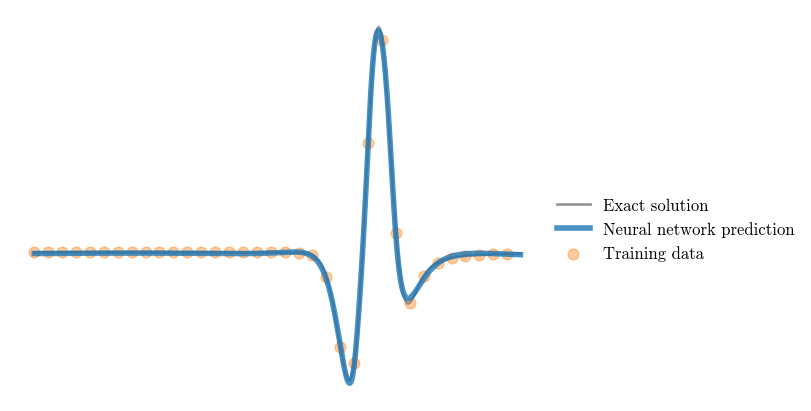

In [14]:
yh = model(t_values).detach()
plot_result(t_values,u_values,t_data,u_data,yh)
plt.show()